In [3]:
import h5py
from tqdm.notebook import tqdm
import scipy
import torch
from torch_geometric.data import Data
import os

import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import illustris_python as il

from easyquery import Query

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

loops = 1
aggr = "multi"

ROOT = Path("..").resolve().parent
tng_base_path = f"{ROOT}/illustris_data/TNG300-1/output"

results_dir = f"{ROOT}/results/predicting-Mstar/gnns-upgraded_{aggr}_loops-{loops}"


c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'


import cmasher as cmr
C0, C1, C2, C3 = cmr.take_cmap_colors('cmr.rainforest', 4, cmap_range=(0.8, 0.2), return_fmt='hex')


In [4]:
data_path = f"{ROOT}/illustris_data/TNG300-1/postprocessing/pyg_data_disperse.h5"
data = pickle.load(open(data_path, 'rb'))

In [5]:
positions = np.concatenate([d.pos for d in data], axis=0)
subcube_index = np.concatenate([np.full((len(d.x), 1), i) for i, d in enumerate(data)], axis=0)

overdensity = np.concatenate([d.overdensity for d in data], axis=0)
is_central = np.concatenate([d.is_central for d in data], axis=0)
positions.shape, subcube_index.shape



((141177, 3), (141177, 1))

In [4]:
D = 2.5

Mhalo = np.concatenate([pd.read_csv(f"{results_dir}/r_link{D}/validation-fold{k}.csv").log_Mhalo for k in range(1,7)], axis=0)
Vmax = np.concatenate([pd.read_csv(f"{results_dir}/r_link{D}/validation-fold{k}.csv").log_Vmax for k in range(1,7)], axis=0)

Mstar_true= np.concatenate([pd.read_csv(f"{results_dir}/r_link{D}/validation-fold{k}.csv").log_Mstar for k in range(1,7)], axis=0)
Mstar_gnn = np.concatenate([pd.read_csv(f"{results_dir}/r_link{D}/validation-fold{k}.csv").p_GNN_3d for k in range(1,7)], axis=0)
Mstar_od = np.concatenate([pd.read_csv(f"{results_dir}/r_link{D}/validation-fold{k}.csv").p_RF_overdensity for k in range(1,7)], axis=0)
Mstar_cw = np.concatenate([pd.read_csv(f"{ROOT}/results/predicting-Mstar/cosmic_web_disperse/validation-fold{k}.csv").p_RF_disperse for k in range(1,7)], axis=0)

assert Mstar_true.shape == Mstar_gnn.shape == Mstar_od.shape == Mstar_cw.shape

In [5]:
df = pd.DataFrame({
    "subcube_index": subcube_index.flat,
    "x": positions[:, 0].flat,
    "y": positions[:, 1].flat,
    "z": positions[:, 2].flat,
    "Mstar_true": Mstar_true.flat,
    "Mstar_gnn": Mstar_gnn.flat,
    "Mstar_od": Mstar_od.flat,
    "Mstar_cw": Mstar_cw.flat,
    "Mhalo": Mhalo.flat,
    "Vmax": Vmax.flat,
    "overdensity": overdensity.flat,
    "is_central": is_central.flat,
})

df.sample(10)

,subcube_index,x,y,z,Mstar_true,Mstar_gnn,Mstar_od,Mstar_cw,Mhalo,Vmax,overdensity,is_central
139318,212,36.634136,18.026716,29.238695,9.307685,9.241781,9.214108,9.227578,11.439100,0.036849,11.439100,True
18033,31,9.007106,28.811750,11.962831,9.498191,9.539824,9.636485,9.483703,10.729882,0.022629,10.729882,False
26189,42,37.948486,11.355859,23.512014,10.517539,10.410569,10.495229,10.464220,12.219307,0.279902,12.219307,True
583,1,8.068107,24.550655,16.875612,9.702541,9.709212,9.682264,9.731516,11.634398,0.126232,11.634398,True
19571,33,28.914288,11.541609,29.458889,10.731593,10.671283,10.614547,10.666435,12.242797,0.332384,12.242797,False
67466,97,10.911043,38.747761,36.853401,9.212691,9.285401,9.285945,9.292152,11.545095,0.061519,11.545095,True
86513,126,7.701778,34.983364,38.197407,10.857259,10.838953,10.922985,10.862392,12.596432,0.417294,12.596432,True
75127,111,6.048976,35.028477,30.389370,10.577838,10.422498,10.408444,10.399499,10.867016,0.259408,10.867016,False
46539,67,35.490868,9.955610,25.198877,10.398396,10.352098,10.382633,10.320391,11.607568,0.244019,11.607568,False
18825,31,14.577822,24.271681,20.256525,9.092999,9.237185,9.180672,9.269699,11.440770,0.051598,11.440770,True


Recall again that OD -> spherical overdensity, cw -> DisPerSE cosmic web parameters. Both of these were trained with a RF along with Mhalo and Vmax.

In [7]:
# df.to_csv(f"{results_dir}/cross-val-results.csv", index=False)

# Visualize

In [8]:
df = pd.read_csv(f"{results_dir}/cross-val-results.csv")

In [6]:
df_i = df[df.subcube_index == 100].copy()

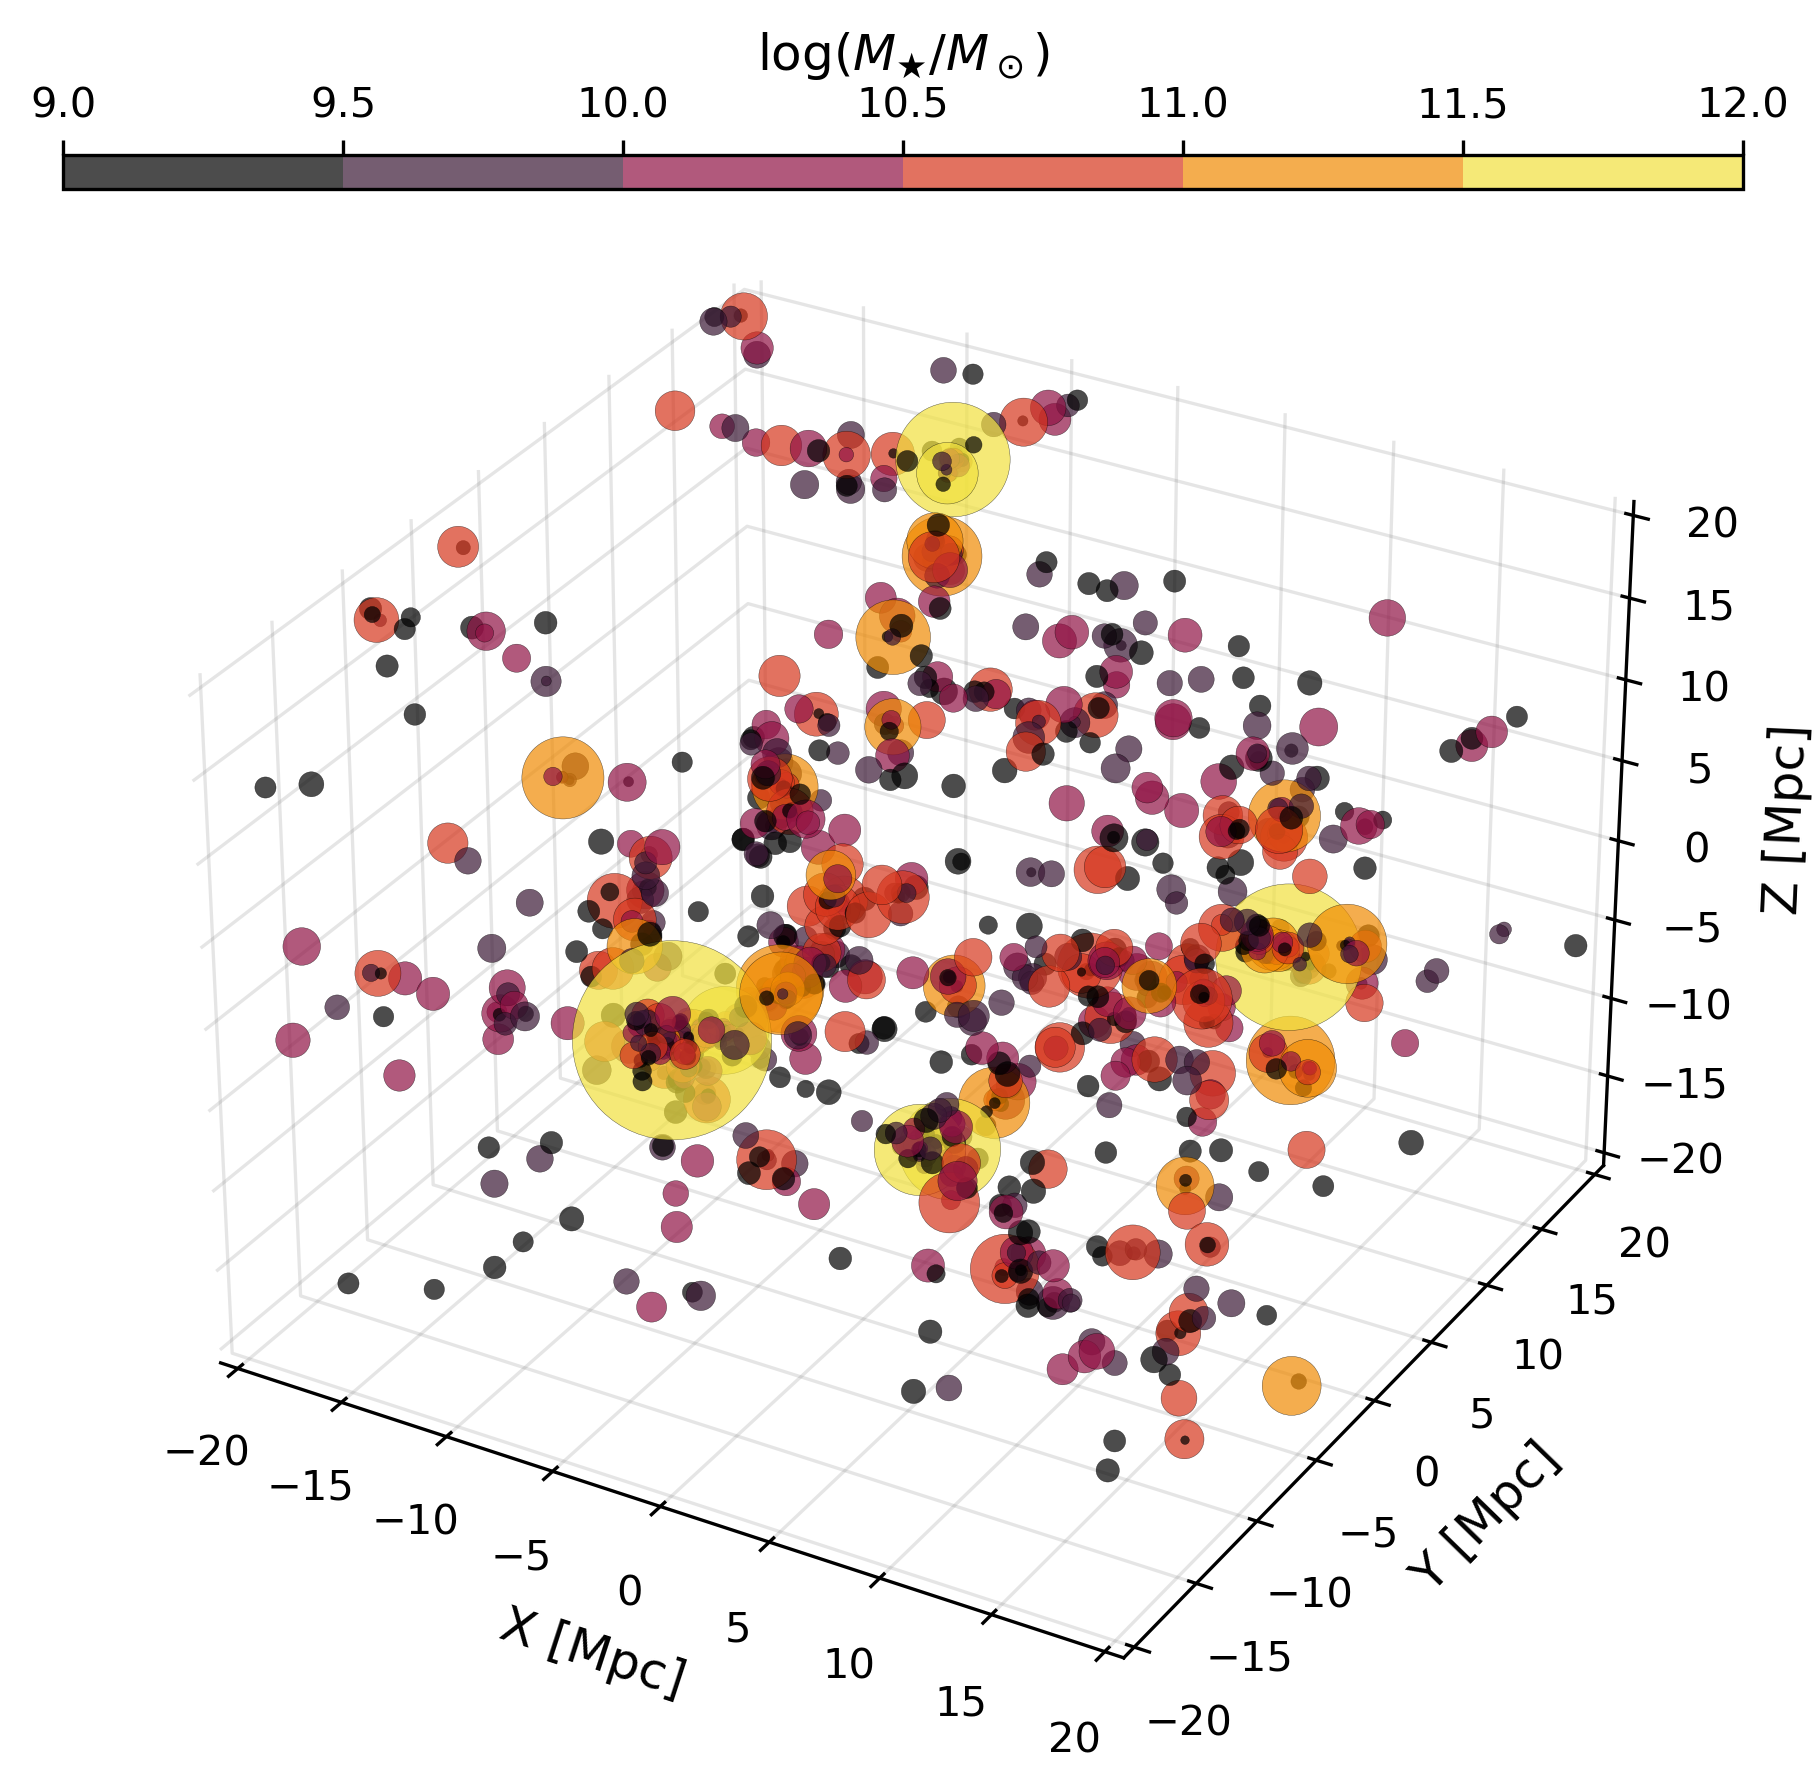

In [60]:
fig = plt.figure(figsize=(7, 8), dpi=300)
ax = fig.add_subplot(projection="3d")

fontsize = 12
pos = df_i[["x", "y", "z"]] - df_i[["x", "y", "z"]].mean(0)

cmap = cmr.get_sub_cmap(cmr.ember, 0., 1, N=6)

# Plot nodes
sc = ax.scatter(pos.x, pos.y, pos.z, s=4**(df_i.Mhalo-9), zorder=1000, vmin=9, vmax=12, alpha=0.7, edgecolor='k', c=df_i.Mstar_true, cmap=cmap, linewidths=0.1)
fig.subplots_adjust(left=0.1, right=0.9)

cb = fig.colorbar(sc, aspect=50, pad=-0.02, location='top')
cb.set_label(r"log($M_\bigstar/M_\odot$)", fontsize=fontsize)

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-20, 20)
ax.set_xlabel("X [Mpc]", fontsize=12)
ax.set_ylabel("Y [Mpc]", fontsize=12)
ax.set_zlabel("Z [Mpc]", fontsize=12)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.yaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.zaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)

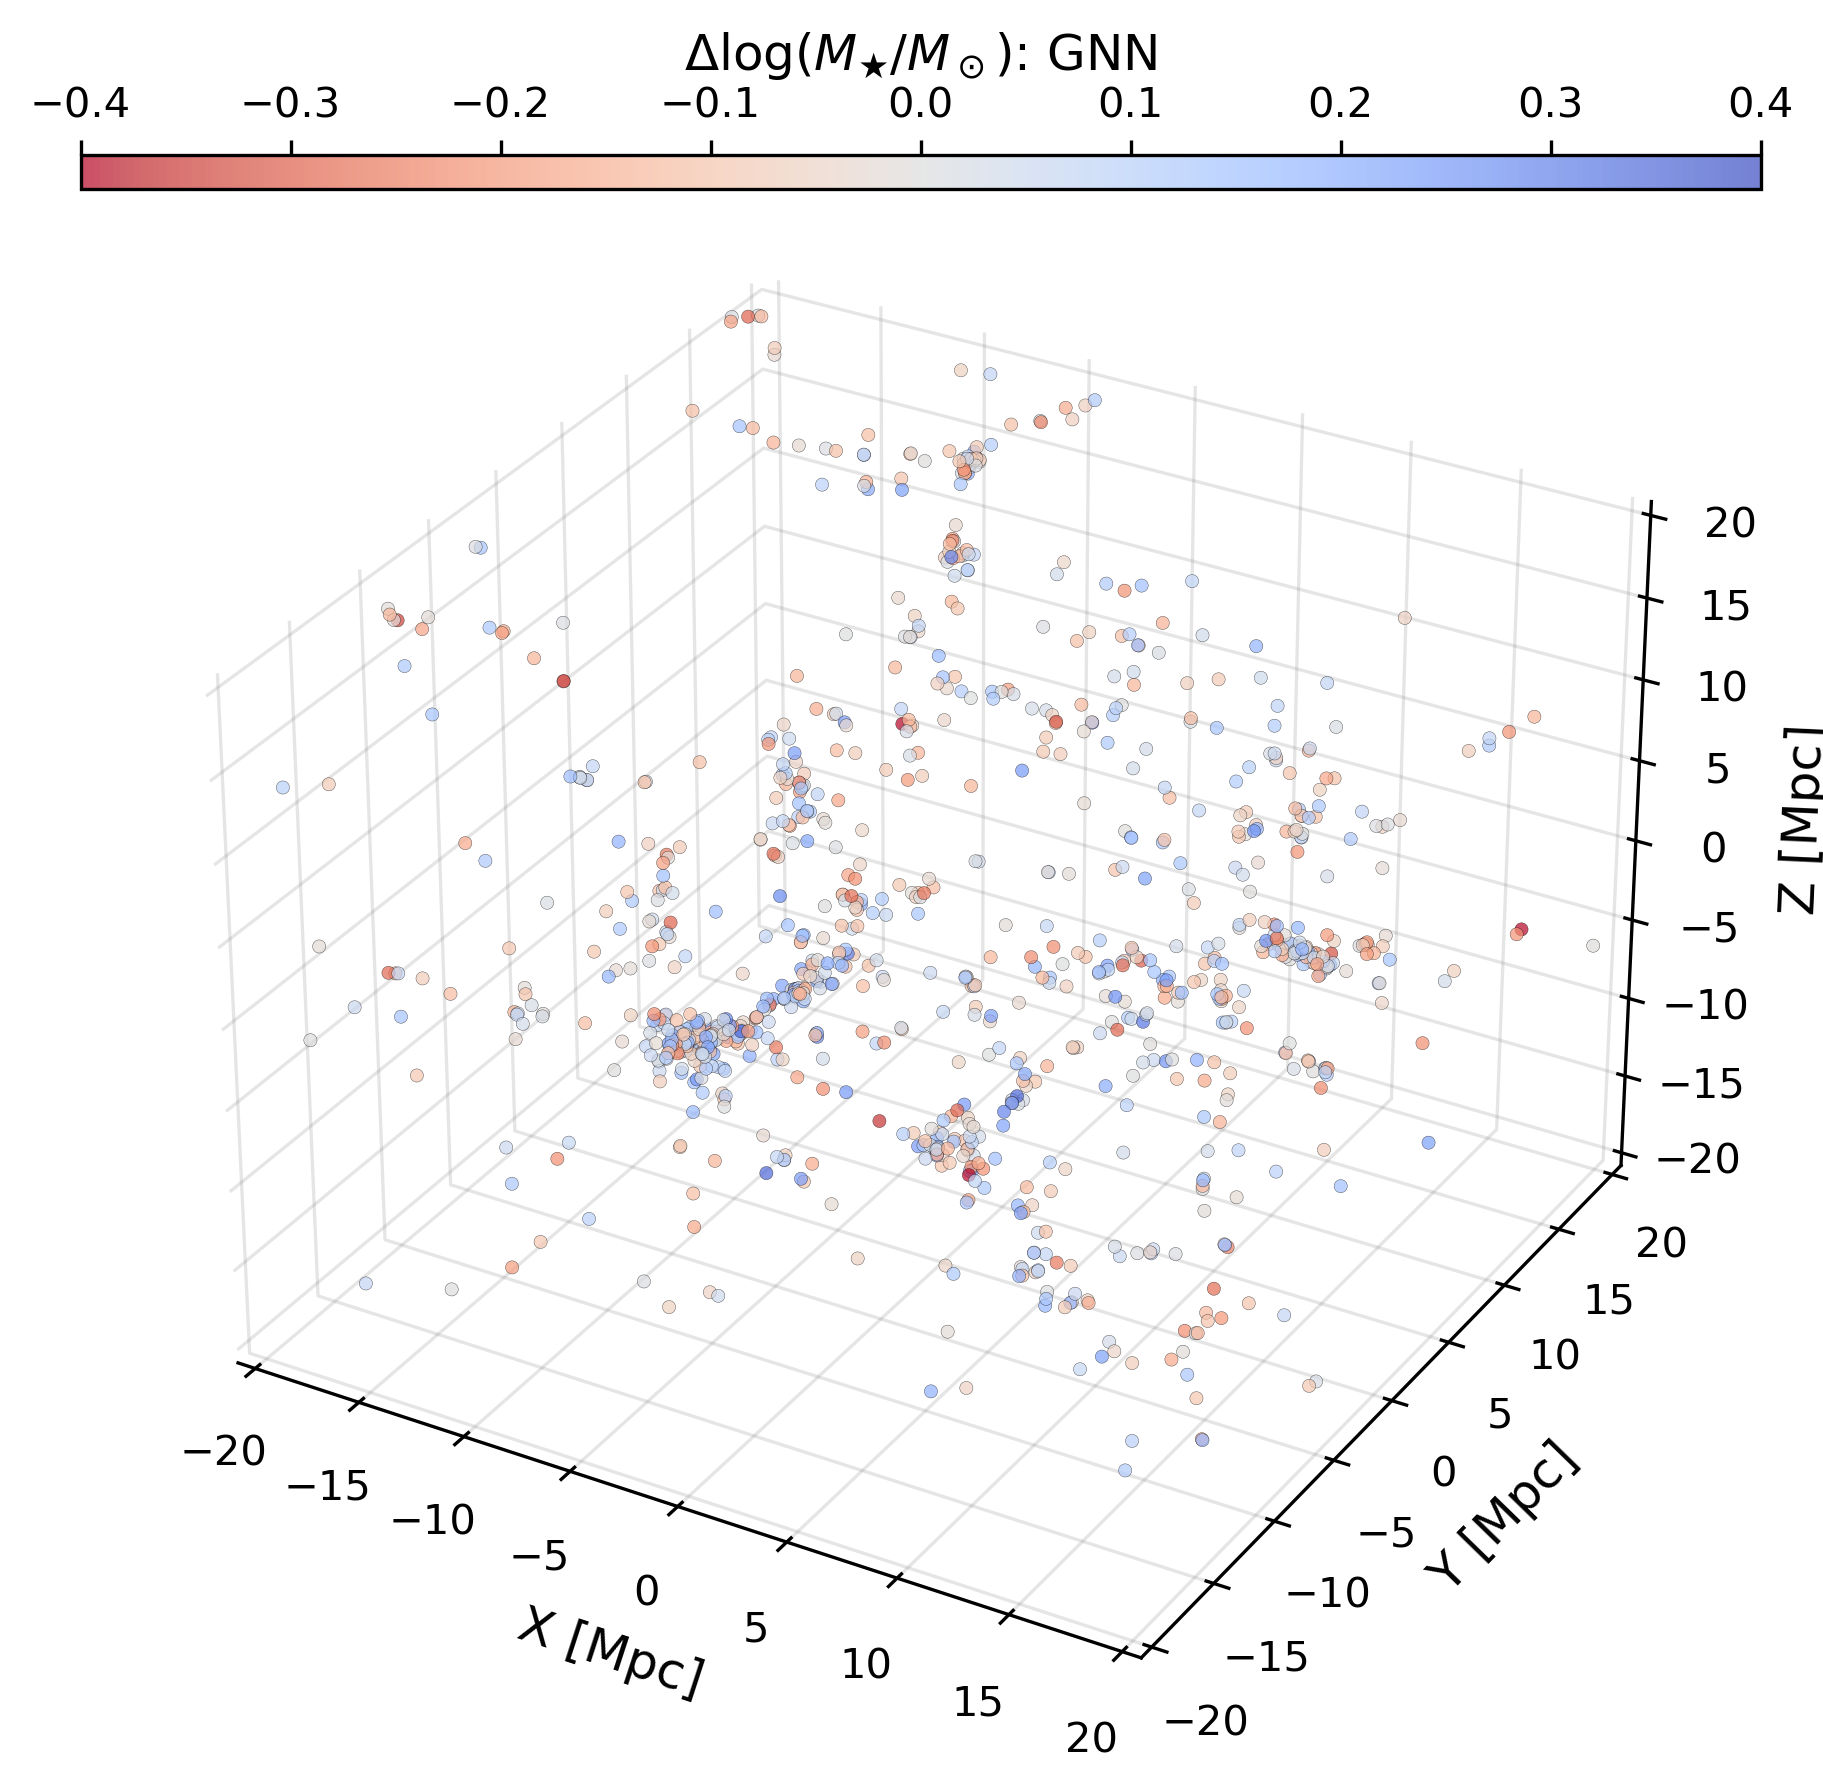

In [70]:
fig = plt.figure(figsize=(7, 8), dpi=300)
ax = fig.add_subplot(projection="3d")

fontsize = 12
pos = df_i[["x", "y", "z"]] - df_i[["x", "y", "z"]].mean(0)

# Plot nodes
sc = ax.scatter(pos.x, pos.y, pos.z, s=10, zorder=1000, vmin=-0.4, vmax=0.4, alpha=0.7, edgecolor='k', c=df_i.Mstar_gnn-df_i.Mstar_true, cmap="coolwarm_r", linewidths=0.1)
fig.subplots_adjust(left=0.1, right=0.9)

cb = fig.colorbar(sc, aspect=50, pad=-0.02, location='top')
cb.set_label(r"$\Delta \log(M_\bigstar/M_\odot)$: GNN", fontsize=fontsize)

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-20, 20)
ax.set_xlabel("X [Mpc]", fontsize=12)
ax.set_ylabel("Y [Mpc]", fontsize=12)
ax.set_zlabel("Z [Mpc]", fontsize=12)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.yaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.zaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)

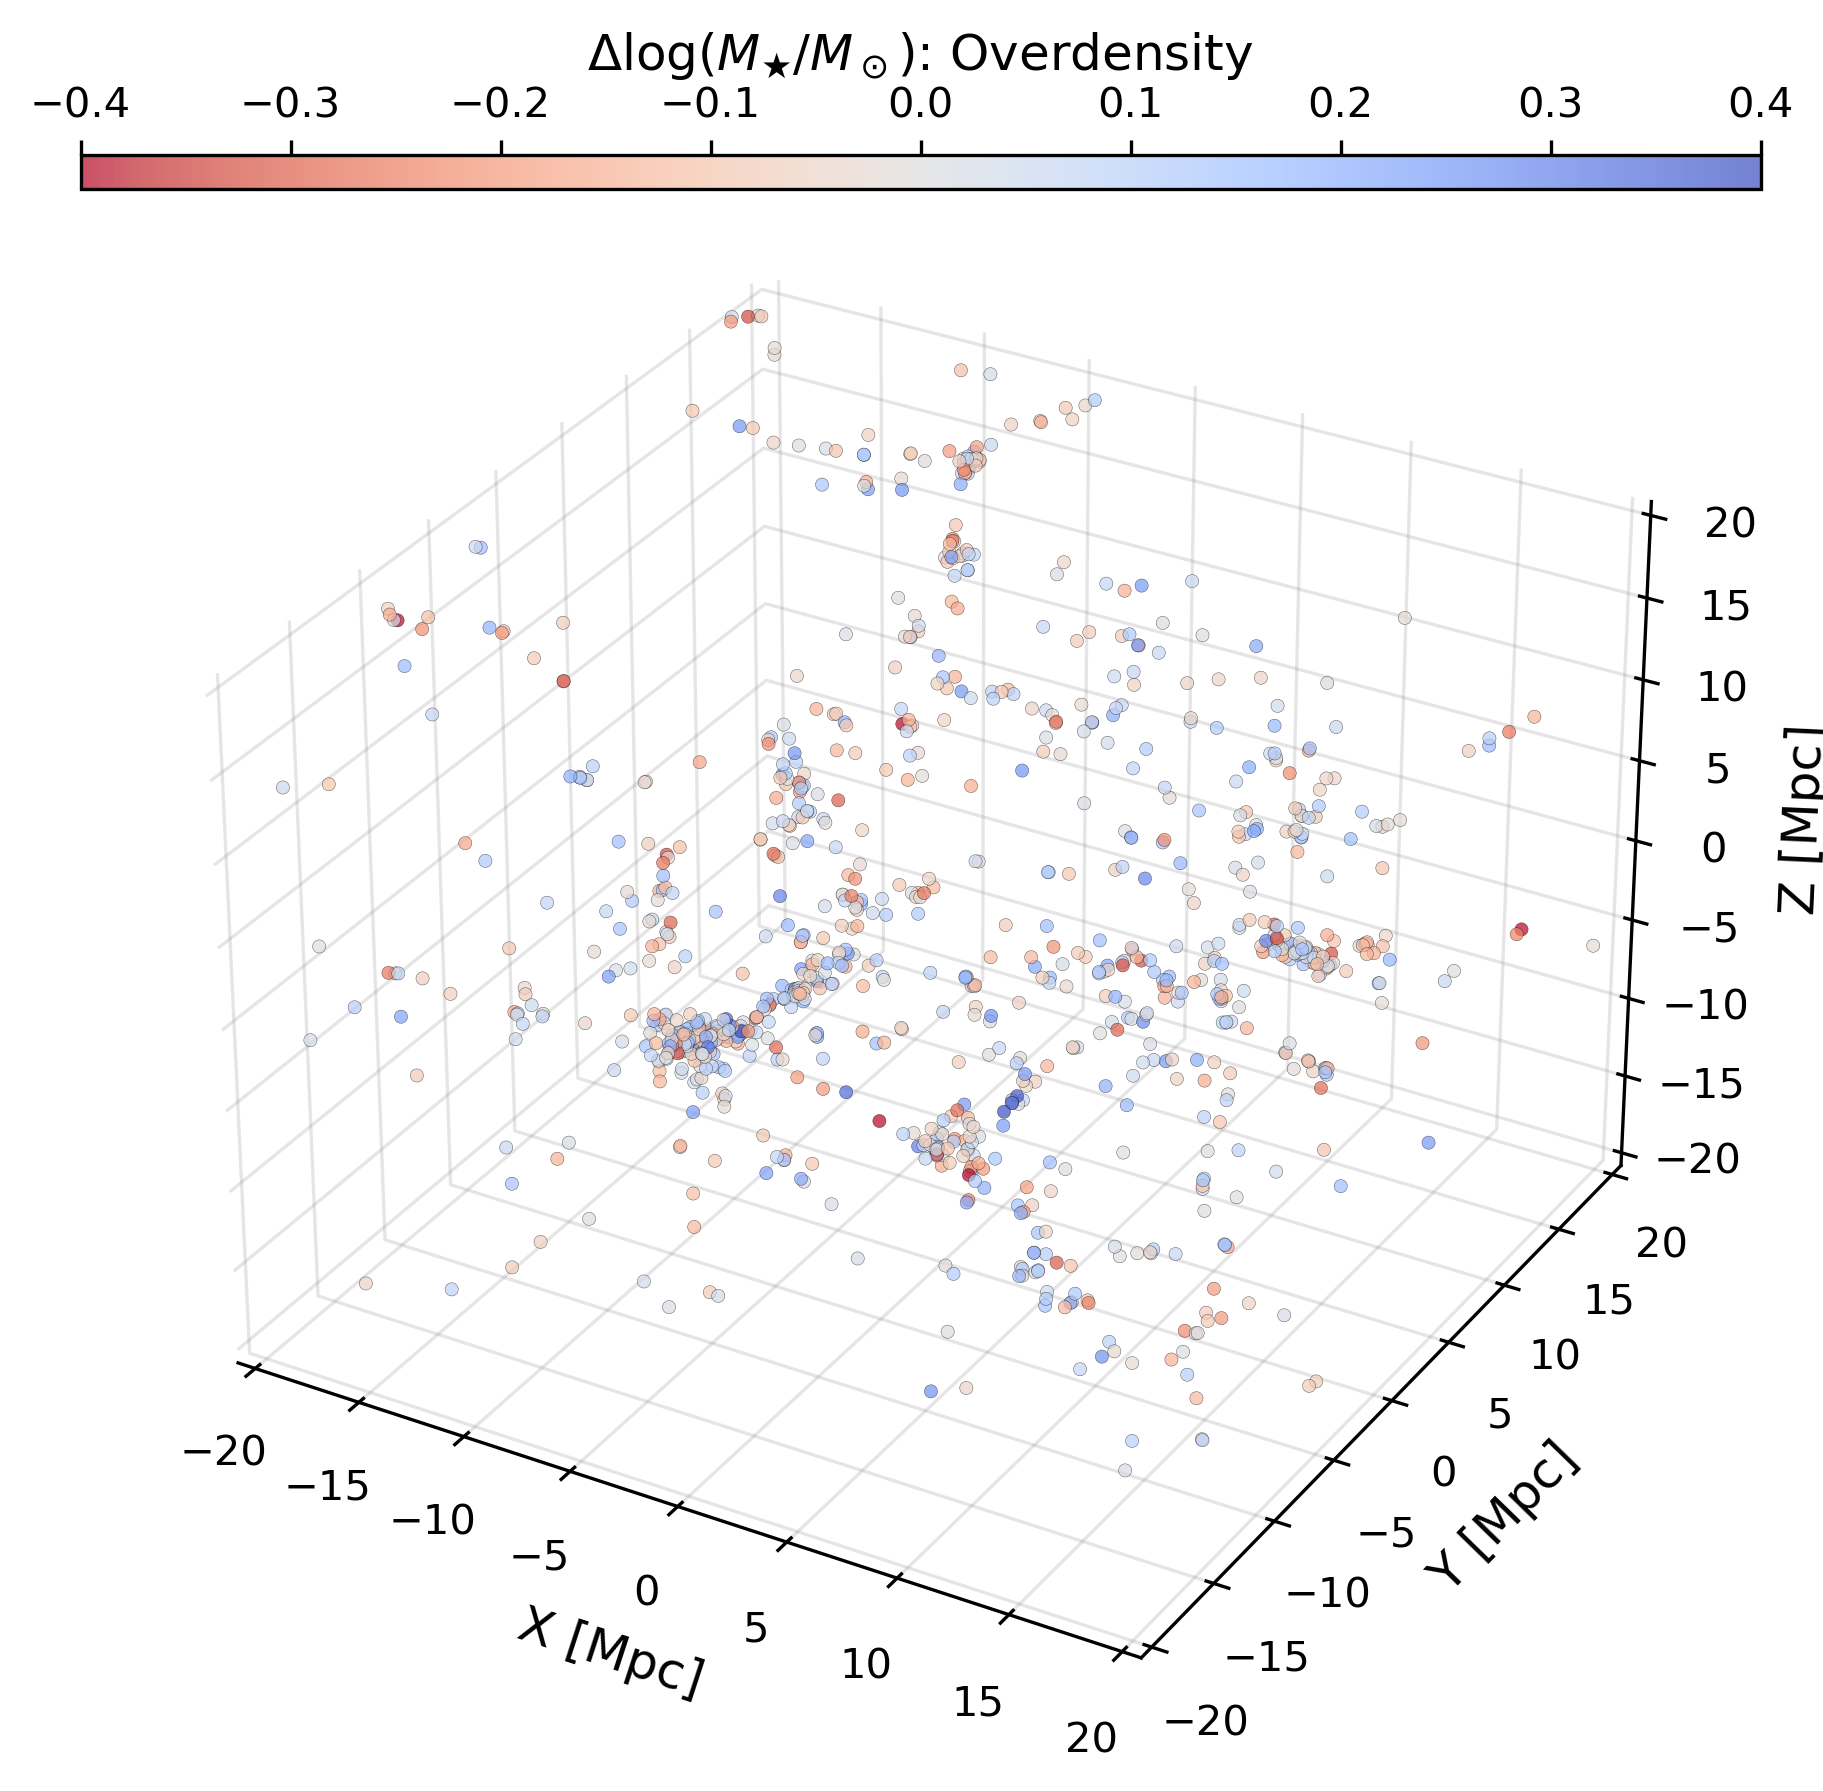

In [72]:
fig = plt.figure(figsize=(7, 8), dpi=300)
ax = fig.add_subplot(projection="3d")

fontsize = 12
pos = df_i[["x", "y", "z"]] - df_i[["x", "y", "z"]].mean(0)

# Plot nodes
sc = ax.scatter(pos.x, pos.y, pos.z, s=10, zorder=1000, vmin=-0.4, vmax=0.4, alpha=0.7, edgecolor='k', c=df_i.Mstar_od-df_i.Mstar_true, cmap="coolwarm_r", linewidths=0.1)
fig.subplots_adjust(left=0.1, right=0.9)

cb = fig.colorbar(sc, aspect=50, pad=-0.02, location='top')
cb.set_label(r"$\Delta \log(M_\bigstar/M_\odot)$: Overdensity", fontsize=fontsize)

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-20, 20)
ax.set_xlabel("X [Mpc]", fontsize=12)
ax.set_ylabel("Y [Mpc]", fontsize=12)
ax.set_zlabel("Z [Mpc]", fontsize=12)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.yaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.zaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)

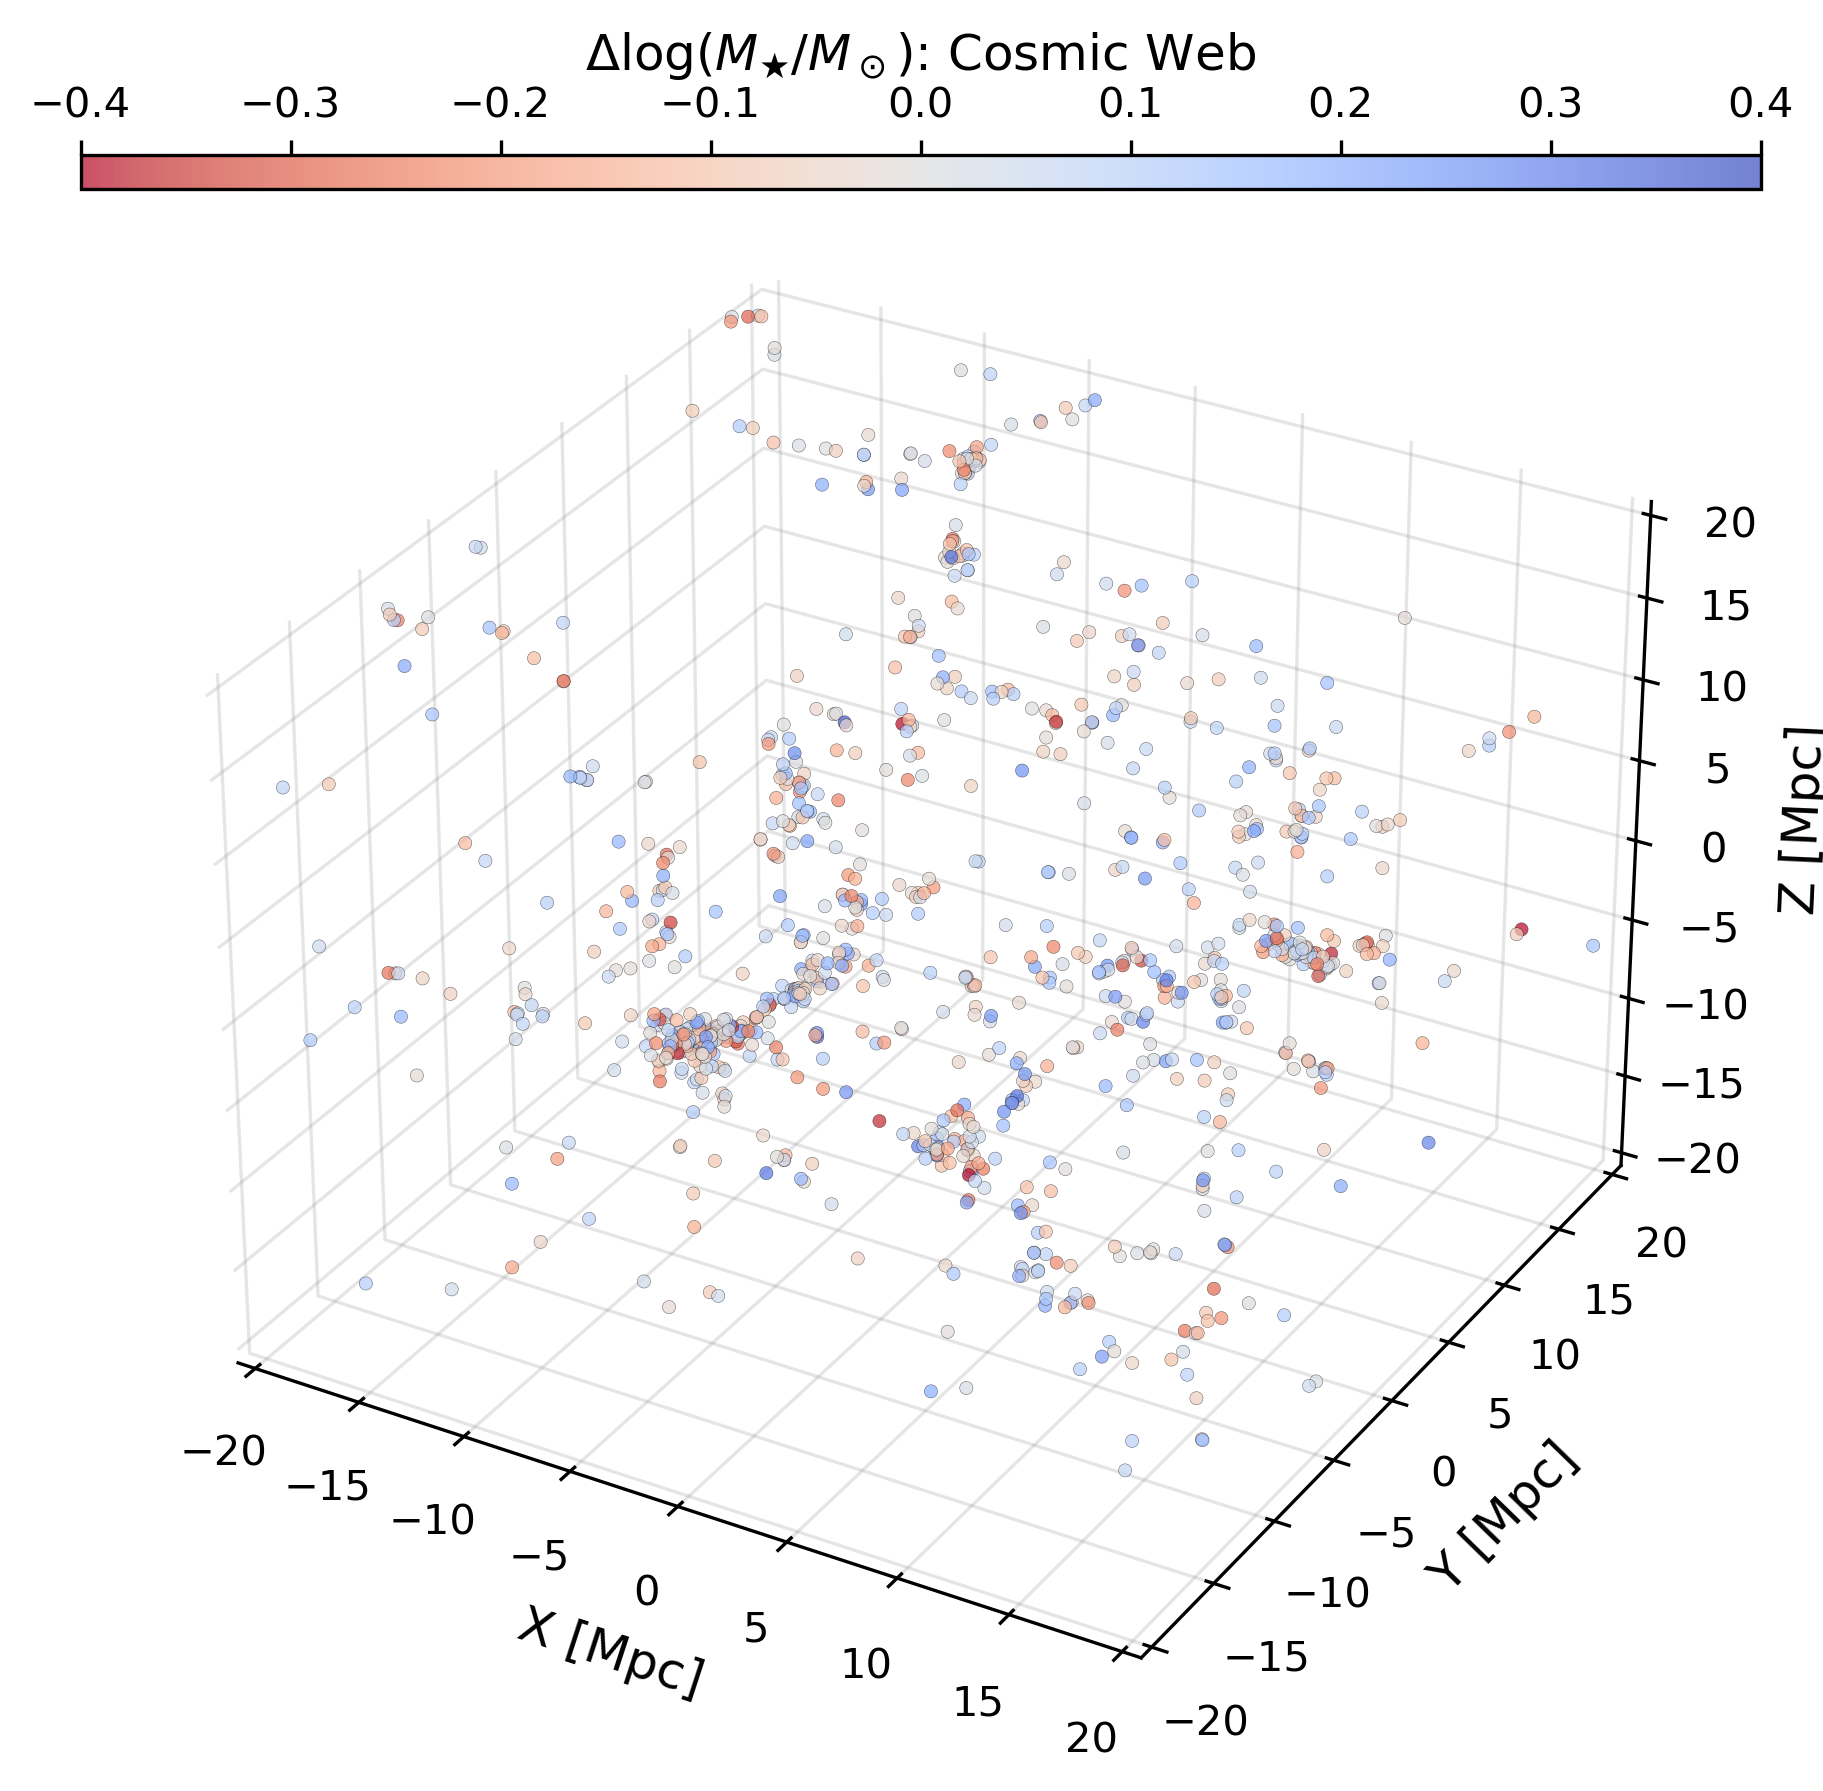

In [73]:
fig = plt.figure(figsize=(7, 8), dpi=300)
ax = fig.add_subplot(projection="3d")

fontsize = 12
pos = df_i[["x", "y", "z"]] - df_i[["x", "y", "z"]].mean(0)

# Plot nodes
sc = ax.scatter(pos.x, pos.y, pos.z, s=10, zorder=1000, vmin=-0.4, vmax=0.4, alpha=0.7, edgecolor='k', c=df_i.Mstar_cw-df_i.Mstar_true, cmap="coolwarm_r", linewidths=0.1)
fig.subplots_adjust(left=0.1, right=0.9)

cb = fig.colorbar(sc, aspect=50, pad=-0.02, location='top')
cb.set_label(r"$\Delta \log(M_\bigstar/M_\odot)$: Cosmic Web", fontsize=fontsize)

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-20, 20)
ax.set_xlabel("X [Mpc]", fontsize=12)
ax.set_ylabel("Y [Mpc]", fontsize=12)
ax.set_zlabel("Z [Mpc]", fontsize=12)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.xaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.yaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)
ax.zaxis._axinfo["grid"]['color'] =  (0.5,0.5,0.5,0.2)

# Power spectra & bispectra

In [4]:
df = pd.read_csv(f"{results_dir}/cross-val-results.csv")

In [30]:
m1 = 10.5
m2 = 11

q = Query(f"Mstar_true >= {m1}", f"Mstar_true < {m2}")

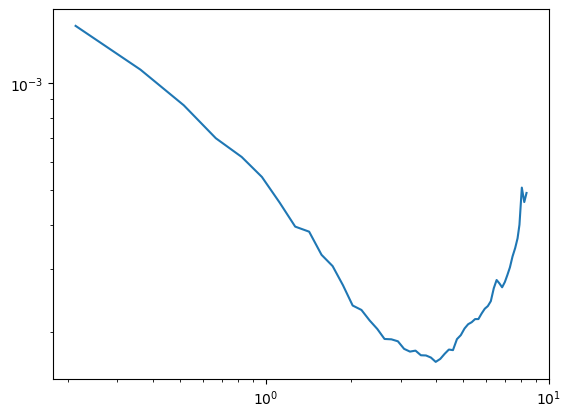

In [34]:
# step 0: install pylians...
import Pk_library as PKL
import MAS_library as MASL

grid = 64            # voxels per side
box_size = 51.7 - 10 # Mpc
MAS = "CIC"          # mass assignment scheme

# TNG300 galaxy density field
delta = np.zeros((grid,grid,grid), dtype=np.float32)
MASL.MA(
    q.filter(df[df.subcube_index == 100])[['x', 'y', 'z']].to_numpy(dtype=np.float32), 
    delta, 
    box_size, 
    MAS=MAS, 
    verbose=False
)

Pk = PKL.Pk(delta, box_size, axis=0, MAS=MAS, verbose=False)

# 3D Pk monopole
k       = Pk.k3D
Pk0     = Pk.Pk[:,0] #monopole

plt.plot(k, Pk0)
plt.xscale('log')
plt.yscale('log')

In [36]:
df

,subcube_index,x,y,z,Mstar_true,Mstar_gnn,Mstar_od,Mstar_cw,Mhalo,Vmax,overdensity,is_central
0,0,33.531036,10.237030,19.033298,11.624547,11.660042,11.645769,11.721059,13.615389,0.734695,13.615389,True
1,0,33.794956,9.915743,18.972916,10.591126,10.633127,10.649242,10.601227,11.716306,0.330444,11.716306,False
2,0,33.361324,9.729468,19.028584,10.237699,10.061037,10.016851,10.028296,11.307609,0.174015,11.307609,False
3,0,33.150400,9.732514,19.202230,10.121473,10.226283,10.266617,10.217091,11.213769,0.208473,11.213769,False
4,0,33.458935,10.167228,19.112300,10.405973,10.417510,10.383761,10.406906,10.584325,0.278973,10.584325,False
...,...,...,...,...,...,...,...,...,...,...,...,...
141172,215,30.873274,0.761823,20.252455,9.453571,9.246311,9.289780,9.244799,11.181200,0.013678,11.181200,True
141173,215,38.943035,2.383863,13.604719,9.242676,9.126018,9.200635,9.119267,11.185719,-0.002330,11.185719,True
141174,215,38.162273,11.555647,9.960646,9.249216,9.267253,9.306184,9.268627,11.160171,0.047254,11.160171,True
141175,215,30.490004,33.606213,15.259901,9.585039,9.318191,9.313436,9.367468,11.148536,0.039921,11.148536,True


In [37]:
m1 = 10.5
m2 = 11

q = Query(f"Mstar_true >= {m1}", f"Mstar_true < {m2}")

N_subcubes = 216

delta_subcubes = np.zeros((N_subcubes, grid, grid, grid), dtype=np.float32)
Pk3d_subcubes = dict()

for n in range(N_subcubes):
    delta = np.zeros((grid,grid,grid), dtype=np.float32)

    MASL.MA(
        q.filter(df[df.subcube_index == n])[['x', 'y', 'z']].to_numpy(dtype=np.float32), 
        delta, 
        box_size, 
        MAS=MAS, 
        verbose=False
    )

    delta_subcubes[n] = delta.copy()

    Pk = PKL.Pk(delta, box_size, axis=0, MAS=MAS, verbose=False)

    # 3D Pk monopole
    k       = Pk.k3D
    Pk0     = Pk.Pk[:,0]

    Pk3d_subcubes[n] = (k, Pk0)

Text(0, 0.5, '$P(k)$  (Mpc$^3$)')

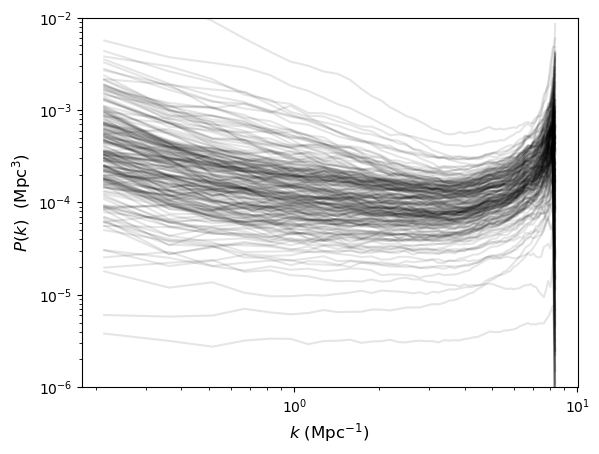

In [39]:
for n in range(N_subcubes):
    plt.plot(*Pk3d_subcubes[n], c='k', alpha=0.1)

plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-6, 1e-2)
plt.xlabel(r'$k$ (Mpc)', fontsize=12)
plt.ylabel(r'$P(k)$  (Mpc$^3$)', fontsize=12)

# 2pt correlation function of galaxies between certain stellar mass ranges

In [6]:
import treecorr

config = {
    "nbins": 20,
    "max_sep": 30,
    "min_sep": 0.03
}

In [10]:
m1 = 9
m2 = 9.5

subcube_index = 100

# needed for corr funcs
box_size = 51.7 - 10
rng = np.random.RandomState(42)
random_pos = (rng.uniform(size=(3, 140000)) - 0.5) * box_size 


In [11]:
df = pd.read_csv(f"{results_dir}/cross-val-results.csv")
df.shape

(141177, 12)

## True galaxies

In [12]:
cat_rand = treecorr.Catalog(x=random_pos[0], y=random_pos[1], z=random_pos[2])

In [13]:
def compute_2pt_all_subcubes(df, query, cat_rand=cat_rand):
    """query should indicate what predictor and the mass range. Some valid examples:
        query = Query("Mstar_true >= 9", "Mstar_true < 10")
        query = Query("Mstar_gnn >= 10.5", "Mstar_gnn < 11")

    Don't include the subindex here, since all subcubes will iterated over in this function.
    """
    df_filtered = query.filter(df)

    all_xi = []
    for subcube_ind in range(216):
        df_ = Query(f"subcube_index == {subcube_ind}").filter(df_filtered)
        cat = treecorr.Catalog(x=df_.x, y=df_.y, z=df_.z)

        # use landy-szalay estimator
        dd = treecorr.NNCorrelation(config)
        dr = treecorr.NNCorrelation(config)
        rr = treecorr.NNCorrelation(config)
        dd.process(cat)
        dr.process(cat,cat_rand)
        rr.process(cat_rand)
        xi, _ = dd.calculateXi(dr=dr, rr=rr)

        all_xi.append(xi)
    r = np.exp(dd.meanlogr)
    return r, all_xi


In [14]:
# m1 = 9
# m2 = 9.5

# group_name = f"{m1:g}_{m2:g}"

# r, xi_true_9_9p5 = compute_2pt_all_subcubes(
#     df, 
#     Query(f"Mstar_true >= {m1}", f"Mstar_true < {m2}"),
#     cat_rand=cat_rand,
# )
# r, xi_gnn_9_9p5 = compute_2pt_all_subcubes(
#     df, 
#     Query(f"Mstar_gnn >= {m1}", f"Mstar_gnn < {m2}"),
#     cat_rand=cat_rand,
# )
# r, xi_od_9_9p5 = compute_2pt_all_subcubes(
#     df, 
#     Query(f"Mstar_od >= {m1}", f"Mstar_od < {m2}"),
#     cat_rand=cat_rand,
# )
# r, xi_cw_9_9p5 = compute_2pt_all_subcubes(
#     df, 
#     Query(f"Mstar_cw >= {m1}", f"Mstar_cw < {m2}"),
#     cat_rand=cat_rand,
# )
# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/r.npy', r)
# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_true_{m1}_{m2}.npy', xi_true_9_9p5)
# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_gnn_{m1}_{m2}.npy', xi_gnn_9_9p5)
# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_od_{m1}_{m2}.npy', xi_od_9_9p5)
# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_cw_{m1}_{m2}.npy', xi_cw_9_9p5)



In [45]:
# m1 = 9.5
# m2 = 10

# group_name = f"{m1:g}_{m2:g}"

# r, xi_true = compute_2pt_all_subcubes(
#     df, 
#     Query(f"Mstar_true >= {m1}", f"Mstar_true < {m2}"),
#     cat_rand=cat_rand,
# )
# r, xi_gnn = compute_2pt_all_subcubes(
#     df, 
#     Query(f"Mstar_gnn >= {m1}", f"Mstar_gnn < {m2}"),
#     cat_rand=cat_rand,
# )
# r, xi_od = compute_2pt_all_subcubes(
#     df, 
#     Query(f"Mstar_od >= {m1}", f"Mstar_od < {m2}"),
#     cat_rand=cat_rand,
# )
# r, xi_cw = compute_2pt_all_subcubes(
#     df, 
#     Query(f"Mstar_cw >= {m1}", f"Mstar_cw < {m2}"),
#     cat_rand=cat_rand,
# )

# # np.save(f'{results_dir}/galaxy-galaxy-corrfunc/r.npy', r)
# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_true_{m1}_{m2}.npy', xi_true)
# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_gnn_{m1}_{m2}.npy', xi_gnn)
# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_od_{m1}_{m2}.npy', xi_od)
# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_cw_{m1}_{m2}.npy', xi_cw)



In [46]:
m1 = 10
m2 = 10.5

group_name = f"{m1:g}_{m2:g}"

r, xi_true = compute_2pt_all_subcubes(
    df, 
    Query(f"Mstar_true >= {m1}", f"Mstar_true < {m2}"),
    cat_rand=cat_rand,
)
r, xi_gnn = compute_2pt_all_subcubes(
    df, 
    Query(f"Mstar_gnn >= {m1}", f"Mstar_gnn < {m2}"),
    cat_rand=cat_rand,
)
r, xi_od = compute_2pt_all_subcubes(
    df, 
    Query(f"Mstar_od >= {m1}", f"Mstar_od < {m2}"),
    cat_rand=cat_rand,
)
r, xi_cw = compute_2pt_all_subcubes(
    df, 
    Query(f"Mstar_cw >= {m1}", f"Mstar_cw < {m2}"),
    cat_rand=cat_rand,
)

# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/r.npy', r)
np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_true_{m1}_{m2}.npy', xi_true)
np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_gnn_{m1}_{m2}.npy', xi_gnn)
np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_od_{m1}_{m2}.npy', xi_od)
np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_cw_{m1}_{m2}.npy', xi_cw)



In [47]:
m1 = 10.5
m2 = 11

group_name = f"{m1:g}_{m2:g}"

r, xi_true = compute_2pt_all_subcubes(
    df, 
    Query(f"Mstar_true >= {m1}", f"Mstar_true < {m2}"),
    cat_rand=cat_rand,
)
r, xi_gnn = compute_2pt_all_subcubes(
    df, 
    Query(f"Mstar_gnn >= {m1}", f"Mstar_gnn < {m2}"),
    cat_rand=cat_rand,
)
r, xi_od = compute_2pt_all_subcubes(
    df, 
    Query(f"Mstar_od >= {m1}", f"Mstar_od < {m2}"),
    cat_rand=cat_rand,
)
r, xi_cw = compute_2pt_all_subcubes(
    df, 
    Query(f"Mstar_cw >= {m1}", f"Mstar_cw < {m2}"),
    cat_rand=cat_rand,
)

# np.save(f'{results_dir}/galaxy-galaxy-corrfunc/r.npy', r)
np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_true_{m1}_{m2}.npy', xi_true)
np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_gnn_{m1}_{m2}.npy', xi_gnn)
np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_od_{m1}_{m2}.npy', xi_od)
np.save(f'{results_dir}/galaxy-galaxy-corrfunc/xi_cw_{m1}_{m2}.npy', xi_cw)



## Make 2pt corr plots

In [86]:
np.percentile(xi_true, 50, axis=0)

array([  1.        ,   1.        ,   1.        ,   1.        ,
         1.        , 643.39146986, 384.15004673, 224.22305268,
       130.47131157,  63.05302588,  31.95997084,  17.45338703,
         8.12715054,   5.39474881,   3.71259733,   2.78475064,
         2.1735133 ,   1.76057338,   1.40251905,   1.04212598])

In [182]:
def plot_2pt_and_scatter(r, xis, color, lw, ls, replace_nans=True):

    if replace_nans:
        xis[(xis <= 1.0)] = np.nan

    l = plt.plot(r, np.nanmedian(xis, axis=0), color=color, ls=ls, lw=lw)

    plt.fill_between(r, *np.nanpercentile(xis, [16, 84], axis=0), color=color, alpha=0.2)
    return l

def plot_relative_2pt(xis, xis_true, color, lw, ls, ax=None, replace_nans=True):

    if replace_nans:
        xis[(xis <= 1.0)] = np.nan

    if ax == None: ax = plt.gca()
    l = ax.plot(r, np.nanpercentile(np.transpose(xis) / np.transpose(xis_true), 50, 1), color=color, ls=ls, lw=lw, alpha=1);
    ax.fill_between(r, *np.nanpercentile(np.transpose(xis) / np.transpose(xis_true), [16, 84], 1), color=color, lw=0, alpha=0.1);
    return l


In [285]:
# pick mass range
m1 = 9
m2 = 9.5

xi_true = np.load(f'{results_dir}/galaxy-galaxy-corrfunc/xi_true_{m1}_{m2}.npy')
xi_gnn = np.load(f'{results_dir}/galaxy-galaxy-corrfunc/xi_gnn_{m1}_{m2}.npy')
xi_od = np.load(f'{results_dir}/galaxy-galaxy-corrfunc/xi_od_{m1}_{m2}.npy')
xi_cw = np.load(f'{results_dir}/galaxy-galaxy-corrfunc/xi_cw_{m1}_{m2}.npy')


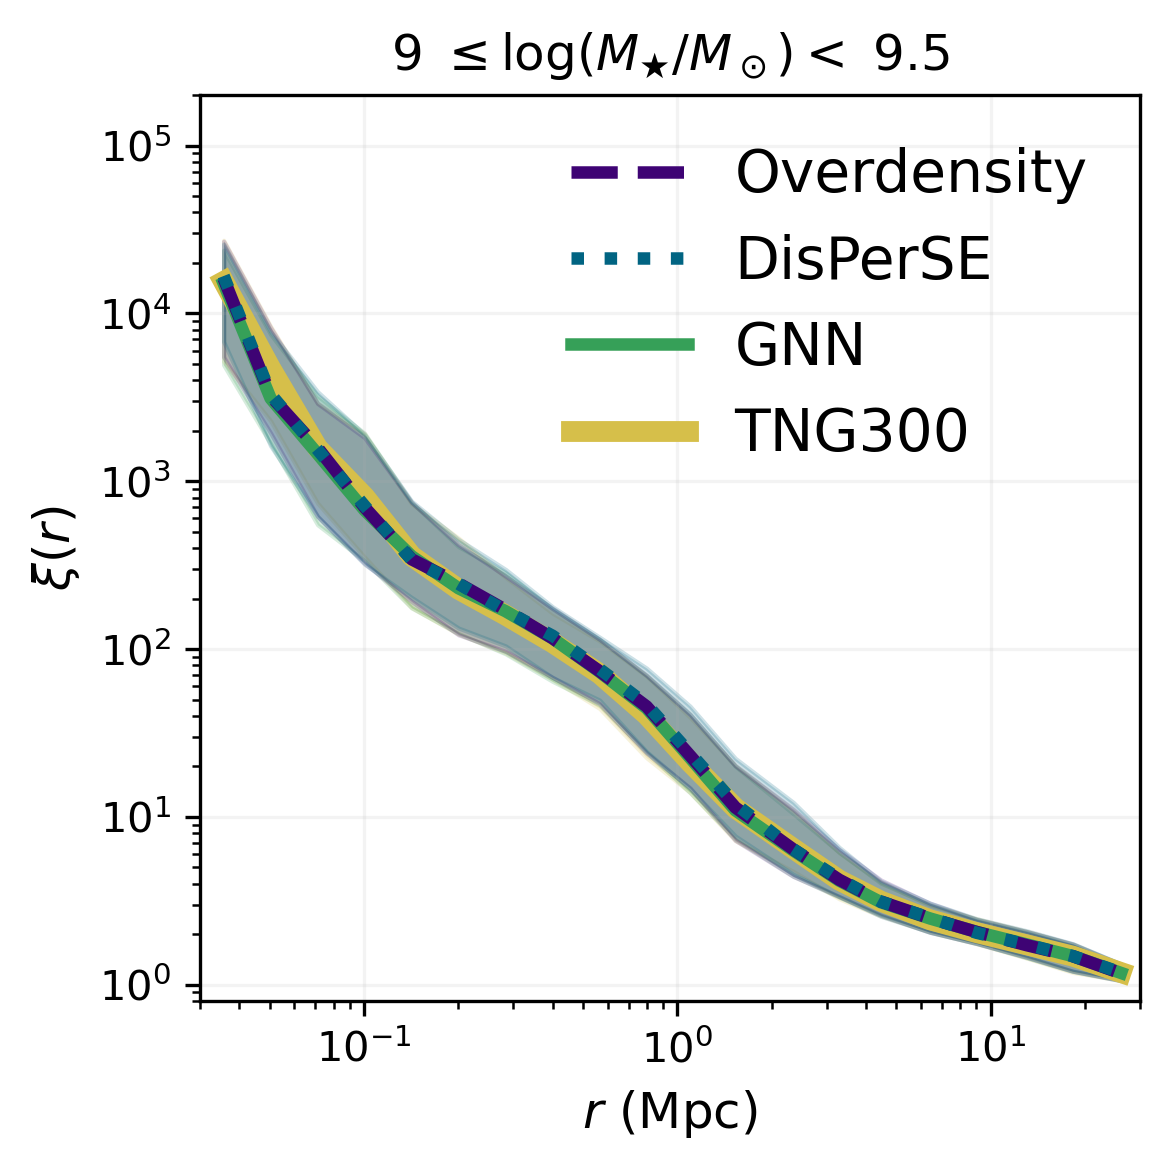

In [286]:
plt.figure(figsize=(4, 4), dpi=300)

l1 = plot_2pt_and_scatter(r, xi_true, color=C0, lw=5, ls="-")
l2 = plot_2pt_and_scatter(r, xi_gnn, color=C1, lw=3, ls="-")
l4 = plot_2pt_and_scatter(r, xi_od, color=C3, lw=3, ls="--")
l3 = plot_2pt_and_scatter(r, xi_cw, color=C2, lw=3, ls=":")

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$r$ (Mpc)', fontsize=12)
plt.ylabel(r'$\xi(r)$', fontsize=12)
plt.ylim(0.8, 2e5)

plt.title(f"{m1} $\\leq \log(M_\\bigstar/M_\\odot) < $ {m2}", fontsize=12)

plt.legend(l4+l3+l2+l1, ["Overdensity", "DisPerSE", "GNN", "TNG300"], loc='upper right', fontsize=14, framealpha=0)
plt.xlim([config["min_sep"], config["max_sep"]])
plt.grid(alpha=0.15)

plt.tight_layout()

plt.savefig(f"{results_dir}/galaxy-galaxy-corrfunc/gg_{m1}-{m2}.pdf")

In [287]:


fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(5, 4), dpi=300, sharex=True)

plot_relative_2pt(xi_od, xi_true, color=C3, lw=2, ls="--", ax=ax1)
plot_relative_2pt(xi_cw, xi_true, color=C2, lw=2, ls=":", ax=ax2)
plot_relative_2pt(xi_gnn, xi_true, color=C1, lw=2, ls="-", ax=ax3)

ax3.set_xscale('log')

ax3.set_xlabel(r'$r$ (Mpc)', fontsize=12)
ax1.set_ylabel(r'$\frac{\xi^{\rm Overdensity}(r)}{\xi^{\rm TNG300}(r)}$', fontsize=18)
ax2.set_ylabel(r'$\frac{\xi^{\rm DisPerSE}(r)}{\xi^{\rm TNG300}(r)}$', fontsize=18)
ax3.set_ylabel(r'$\frac{\xi^{\rm GNN}(r)}{\xi^{\rm TNG300}(r)}$', fontsize=18)

ax3.set_xlim([config["min_sep"], config["max_sep"]])

fig.suptitle(f"${m1} \\leq \\log(M_\\bigstar/M_\\odot) < {m2}$", fontsize=14)
fig.subplots_adjust(hspace=0.025)

from matplotlib.ticker import MultipleLocator # absolutely ridiculous but okay

for ax in [ax1, ax2, ax3]:
    ax.axhline(1, c="k", lw=1)
    ax.set_ylim(0.75, 4/3)
    ax.set_yscale("log")
    ax.yaxis.set_minor_locator(MultipleLocator(100))
    ax.set_yticks(ticks=[0.8, 1, 1.25], labels=[0.8, 1, 1.25])
    ax.grid(alpha=0.15)

plt.tight_layout()

plt.savefig(f"{results_dir}/galaxy-galaxy-corrfunc/gg-ratio_{m1}-{m2}.pdf")

# Stellar mass function

In [210]:
df = pd.read_csv(f"{results_dir}/cross-val-results.csv")
volume = 216 * (51.7 - 10)**3 # Mpc

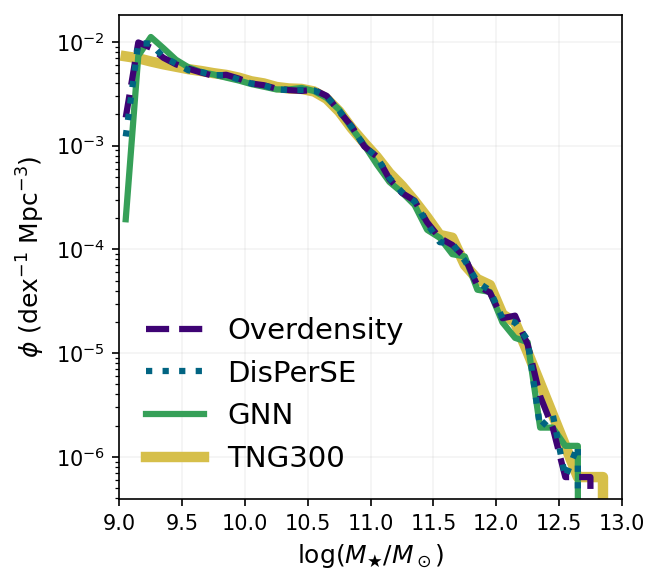

In [278]:
dbin = 0.1

N_true, mass_edges = np.histogram(df.Mstar_true, bins=np.arange(9, 14., dbin))
N_gnn, mass_edges = np.histogram(df.Mstar_gnn, bins=np.arange(9, 14., dbin))
N_od, mass_edges = np.histogram(df.Mstar_od, bins=np.arange(9, 14., dbin))
N_cw, mass_edges = np.histogram(df.Mstar_cw, bins=np.arange(9, 14., dbin))

plt.figure(figsize=(4.5, 4), dpi=150)
l1 = plt.plot(
    (mass_edges[1:] + mass_edges[:-1]) / 2 ,  
    N_true / dbin / volume,
    c=C0,
    ls="-",
    lw=5,
    label="TNG300"
)

l2 = plt.plot(
    (mass_edges[1:] + mass_edges[:-1]) / 2 ,  
    N_gnn / dbin / volume,
    c=C1,
    ls="-",
    lw=3,
    label="GNN"
)

l4 = plt.plot(
    (mass_edges[1:] + mass_edges[:-1]) / 2 ,  
    N_od / dbin / volume,
    c=C3,
    ls="--",
    lw=3,
    label="Overdensity"
)

l3 = plt.plot(
    (mass_edges[1:] + mass_edges[:-1]) / 2 ,  
    N_cw / dbin / volume,
    c=C2,
    ls=":",
    lw=3,
    label="DisPerSE"
)

plt.yscale('log')
plt.xlabel(r"$\log(M_\bigstar/M_\odot)$", fontsize=12)
plt.ylabel(r"$\phi$ (dex$^{-1}$ Mpc$^{-3}$)", fontsize=12)
plt.grid(alpha=0.15)
plt.xlim(9, 13)

plt.legend(l4+l3+l2+l1, ["Overdensity", "DisPerSE", "GNN", "TNG300"], loc="lower left", fontsize=14, framealpha=0)
plt.tight_layout()
plt.savefig(f"{results_dir}/stellar-mass-function.pdf")